In [1]:
# Load Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

import seaborn as sns
from sklearn.cluster import KMeans

In [2]:
# Concatenating PBP scoring files
pbp_sc_files = []
for i in np.arange(1,22):
    name = 'pbpstats_export-{}.csv'.format(i)
    file = pd.read_csv(name)
    file['Season'] = 2022-i
    pbp_sc_files.append(file)
pbp_sc = pd.concat(pbp_sc_files)

# Final PBP scoring csv
pbp_sc.to_csv('pbp_sc.csv')

In [3]:
# Concatenating PBP assist files
pbp_as_files = []
for i in np.arange(-42,-21):
    name = 'pbpstats_export-{}.csv'.format(-i)
    file = pd.read_csv(name)
    file['Season'] = 2000-21-i
    pbp_as_files.append(file)    
pbp_as = pd.concat(pbp_as_files)

# Final PBP assist csv
pbp_as.to_csv('pbp_as.csv')

In [2]:
# Reading in csv files
pbp_score = pd.read_csv('pbp_sc.csv')
pbp_assist = pd.read_csv('pbp_as.csv')
nba_pos = pd.read_csv('NBA Players.csv')
seasonStats1950to2017 = pd.read_csv('Season_Stats_1950to2017.csv')
seasonStats2017to2019 = pd.read_csv('Season_Stats_2017to2019.csv')
seasonStats2019to2021 = pd.read_csv('Season_Stats_2019to2021.csv')

In [3]:
# Drop data from before 2000-2001 season
seasonStats2000to2017 = seasonStats1950to2017[seasonStats1950to2017['Year'] >= 2001]
# Reset index to default so idx doesn't start at some random value
seasonStats2000to2017 = seasonStats2000to2017.reset_index()
# Drop some irrelevant columns
seasonStats2000to2017 = seasonStats2000to2017.drop(['index', 'Unnamed: 0', 'blanl', 'blank2', 'Pos'], axis = 1)
# Change the datatype of year (= season) from float64 to int
seasonStats2000to2017 = seasonStats2000to2017.astype({'Year': int})

In [4]:
# Add missing columns into 2019 to 2021 data
seasonStats2019to2021['FG%'] = round(seasonStats2019to2021['FG']/seasonStats2019to2021['FGA'], 3)
seasonStats2019to2021['2P%'] = round(seasonStats2019to2021['2P']/seasonStats2019to2021['2PA'],3)
seasonStats2019to2021['3P%'] = round(seasonStats2019to2021['3P']/seasonStats2019to2021['3PA'],3)
seasonStats2019to2021['FT%'] = round(seasonStats2019to2021['FT']/seasonStats2019to2021['FTA'],3)
seasonStats2019to2021['eFG%'] = round(((seasonStats2019to2021['FG'] + (0.5*seasonStats2019to2021['3P']))/
                                 seasonStats2019to2021['FGA']),3)
seasonStats2019to2021['TS%'] = round(((seasonStats2019to2021['PTS'])/
                                (2*(seasonStats2019to2021['FGA'])+(0.44*seasonStats2019to2021['FTA']))),3)

In [5]:
# Drop extraneous columns from 2017 to 2019 and 2019 to 2021 data
seasonStats2017to2019 = seasonStats2017to2019.drop(['ORtg','DRtg', 'Lg'], axis = 1)
seasonStats2019to2021 = seasonStats2019to2021.drop(['ORtg','DRtg', 'Lg'], axis = 1)

In [6]:
# Drop all rows with NaNs from 2017 to 2019 data. There are rows of NaNs at the end of the 2017 to 2019 dataframe.
seasonStats2017to2019 = seasonStats2017to2019.dropna(how = 'all')

In [7]:
# Renaming and reordering columns across the 3 dfs
seasonStats2000to2017 = seasonStats2000to2017.rename(columns = {'Year': 'Season'})
cols = list(seasonStats2000to2017.columns)
seasonStats2017to2019 = seasonStats2017to2019[cols]
seasonStats2019to2021 = seasonStats2019to2021[cols]

In [8]:
# Converting Season column values to be same across the 3 dfs
for i in np.arange(len(seasonStats2017to2019)):
    seasonStats2017to2019.loc[i,'Season'] = int(seasonStats2017to2019.loc[i,'Season'][-2:])+2000

for i in np.arange(len(seasonStats2019to2021)):
    seasonStats2019to2021.loc[i,'Season'] = int(seasonStats2019to2021.loc[i,'Season'][-2:])+2000

In [9]:
# Combining the 3 df into a single stathead df
seasonStats = [seasonStats2000to2017,seasonStats2017to2019,seasonStats2019to2021]
nba = pd.concat(seasonStats)

In [10]:
# Cleaning Team Names
nba = nba.rename(columns = {'tm': 'team'})
nba.columns = [header.lower() for header in nba.columns]

# Changing team names to modern abbreviations
nba = nba.replace({'team':{
    'CHO': 'CHA',
    'CHH': 'CHA',
    'BRK': 'BKN',
    'NJN': 'BKN',
    'VAN': 'MEM',
    'PHO': 'PHX',
    'NOH': 'NOP',
    'NOK': 'NOP',
    'SEA': 'OKC',
}})

In [11]:
## Addressing player names with accents
names = nba.player.str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
nba.player = names

In [12]:
# Removing duplicate rows with players playing for multiple teams in one season
# Keeping row of aggregate stats for that player for that season

nba = nba.drop_duplicates(subset = ['player','season'])

In [13]:
# 70% mins cutoff
mins70 = list(nba.groupby('season').mp.quantile(q=0.3))
all_bl = [False]*len(nba)
year = 2001
for i in np.arange(len(mins70)):
    bl = np.logical_and(nba.season==year , nba.mp > mins70[i])
    all_bl = np.logical_or(all_bl, bl)
    year += 1

In [14]:
# Assigning final rows of df (NEED TO ADD PBP though)
nba_filtered = nba.loc[all_bl]

In [15]:
# Change datatypes of certain columns to match their true type
nba_filtered = nba_filtered.astype({'season': int, 'age': int, 'g': int, 'gs': int, 'mp': int, 'fg': int, 'fga': int,
                                  '3p': int, '3pa': int, '2p': int, '2pa': int, 'ft': int, 'fta': int, 'orb': int,
                                  'drb': int, 'trb': int, 'ast': int, 'stl': int, 'blk': int, 'tov': int, 'pf': int,
                                  'pts': int})
nba_filtered.head()

,season,player,age,tm,g,gs,mp,per,ts%,3par,...,ft%,orb,drb,trb,ast,stl,blk,tov,pf,pts
2,2001,Shareef Abdur-Rahim,24,VAN,81,81,3241,19.1,0.549,0.050,...,0.834,175,560,735,250,90,77,231,238,1663
4,2001,Courtney Alexander,23,TOT,65,24,1382,11.6,0.484,0.080,...,0.820,42,101,143,62,45,5,75,139,618
7,2001,Ray Allen,25,MIL,82,82,3129,22.9,0.610,0.357,...,0.888,101,327,428,374,124,20,204,192,1806
9,2001,John Amaechi,30,ORL,82,36,1710,8.7,0.455,0.012,...,0.631,77,191,268,74,28,29,124,175,650
10,2001,Derek Anderson,26,SAS,82,82,2859,17.1,0.542,0.255,...,0.851,75,288,363,301,120,14,165,188,1269


In [16]:
# Drop some irrelevant, unnecessary, and/or redundant columns from PBP data
pbp_score = pbp_score.drop(['Unnamed: 0', 'TeamAbbreviation', 'GamesPlayed', 'Minutes', 'Points','FG2M', 'FG2A',
                            'Fg2Pct', 'FG3M', 'FG3A', 'Fg3Pct', 'FG3APct','EfgPct', 'TsPct','Usage'], axis = 1)
pbp_assist = pbp_assist.drop(['Unnamed: 0', 'TeamAbbreviation', 'GamesPlayed', 'Minutes', 'Assists'], axis = 1)

In [17]:
# Tidying up columns in PBP data
pbp_score.columns = [header.lower() for header in pbp_score.columns]
pbp_assist.columns = [header.lower() for header in pbp_assist.columns]

In [18]:
# Rename name to score for pbp
pbp_score = pbp_score.rename(columns = {'name' : 'player'})
pbp_assist = pbp_assist.rename(columns = {'name' : 'player'})

# Merge 2 pbp files
pbp = pbp_score.merge(pbp_assist)

In [19]:
# Merge dfs from the 2 different datasets to create single df
nba_1 = nba_filtered.merge(pbp, how = 'inner', on = ['player', 'season'])
# nba_1.head(3)

In [20]:
# Adjusting player names of nba player position df
pos_names = nba_pos.player.str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
nba_pos.player = pos_names
nba = nba_1.merge(nba_pos, on = 'player', how = 'left')
# nba

In [21]:
# Manually adding position of 1 player, Omer Asik
omer_i = list(nba.loc[nba.pos.isnull()].index)
nba.loc[omer_i,'pos'] = "C"

In [22]:
nba.columns

Index(['season', 'player', 'age', 'tm', 'g', 'gs', 'mp', 'per', 'ts%', '3par',
       'ftr', 'orb%', 'drb%', 'trb%', 'ast%', 'stl%', 'blk%', 'tov%', 'usg%',
       'ows', 'dws', 'ws', 'ws/48', 'obpm', 'dbpm', 'bpm', 'vorp', 'fg', 'fga',
       'fg%', '3p', '3pa', '3p%', '2p', '2pa', '2p%', 'efg%', 'ft', 'fta',
       'ft%', 'orb', 'drb', 'trb', 'ast', 'stl', 'blk', 'tov', 'pf', 'pts',
       'offposs', 'nonheavefg3pct', 'ftpoints', 'ptsassisted2s',
       'ptsunassisted2s', 'ptsassisted3s', 'ptsunassisted3s', 'assisted2spct',
       'nonputbacksassisted2spct', 'assisted3spct', 'shotqualityavg',
       'ptsputbacks', 'fg2ablocked', 'fg2apctblocked', 'fg3ablocked',
       'fg3apctblocked', 'assistpoints', 'twoptassists', 'threeptassists',
       'atrimassists', 'shortmidrangeassists', 'longmidrangeassists',
       'corner3assists', 'arc3assists', 'pos'],
      dtype='object')

In [31]:
nba.head()

,season,player,age,tm,g,gs,mp,per,ts%,3par,...,fg3apctblocked,assistpoints,twoptassists,threeptassists,atrimassists,shortmidrangeassists,longmidrangeassists,corner3assists,arc3assists,pos
0,2001,Shareef Abdur-Rahim,24,VAN,81,81,3241,19.1,0.549,0.050,...,0.015625,556,194,56,58,25,111,9,47,F
1,2001,Courtney Alexander,23,TOT,65,24,1382,11.6,0.484,0.080,...,0.000000,131,55,7,19,6,30,2,5,G
2,2001,Ray Allen,25,MIL,82,82,3129,22.9,0.610,0.357,...,0.004283,846,276,98,101,78,97,36,62,G
3,2001,John Amaechi,30,ORL,82,36,1710,8.7,0.455,0.012,...,0.000000,171,51,23,31,6,14,3,20,C
4,2001,Derek Anderson,26,SAS,82,82,2859,17.1,0.542,0.255,...,0.007905,674,229,72,115,51,63,33,39,G


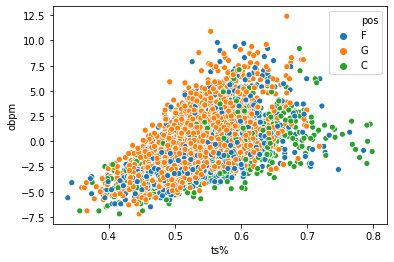

In [23]:
# OBPM - Just getting ideas down, nothing great yet
sns.scatterplot(
    x = nba.loc[:,'ts%'],
    y = nba.loc[:,'obpm'],
    hue = nba.pos
)
plt.show()

In [81]:
def corr_pos(xvar, yvar):
    colors = ['lightskyblue','tab:green','red']
    for i in np.arange(len(nba.pos.unique())):
        position = nba.pos.unique()[i]
        # Corr
        x = nba.groupby('pos').get_group(position).loc[:,xvar]
        y = nba.groupby('pos').get_group(position).loc[:,yvar]
        corr = x.corr(y)
        print(f'For {position}: correlation between {xvar} and {yvar}: {corr : .4f}')
        # Scatter
        fig, ax = plt.subplots()
        ax.scatter(
            list(nba.groupby('pos').get_group(position).loc[:,xvar]),
            nba.groupby('pos').get_group(position).loc[:,yvar],
            color = colors[i],
            alpha = 0.3)
        ax.set_xlabel(xvar)
        ax.set_ylabel(yvar)
        ax.set_title(position)
        plt.tight_layout()
        plt.show()

In [57]:
from sklearn.linear_model import LinearRegression
def multiLinRegbyPos(xvar, yvar):
    '''
    xvar = list of column names 
    '''
    colors = ['lightskyblue','tab:green','red']
    for i in np.arange(len(nba.pos.unique())):
        position = nba.pos.unique()[i]
        # Corr
        grouped_x = nba.groupby('pos').get_group(position).loc[:,xvar]
        grouped_y = nba.groupby('pos').get_group(position).loc[:,yvar]
        multi_model = LinearRegression()
        multi_model.fit(grouped_x[xvar], grouped_y[yvar])
        r2 = multi_model.score(grouped_x[xvar], grouped_y[yvar])
        print(f'For {position}: R^2 between {xvar} and {yvar}: {r2 : .4f}')
        # Scatter
        for j in range(0,len(xvar)):
            fig, ax = plt.subplots()
            ax.scatter(
                grouped_x[xvar[j]],
                multi_model.predict(grouped_x),
                color = colors[i],
                alpha = 0.3)
            ax.set_xlabel(xvar)
            ax.set_ylabel(yvar)
            ax.set_title(position)
            plt.tight_layout()
            plt.show()

For F: R^2 between ['assistpoints', 'ptsunassisted2s'] and ['obpm']:  0.4477


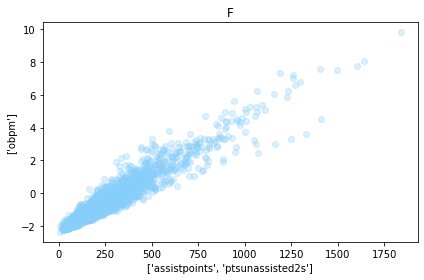

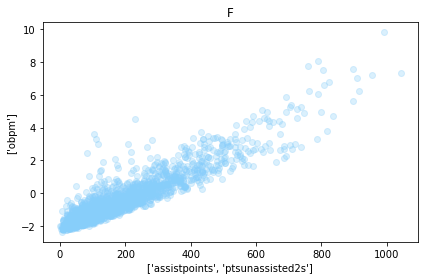

For G: R^2 between ['assistpoints', 'ptsunassisted2s'] and ['obpm']:  0.4377


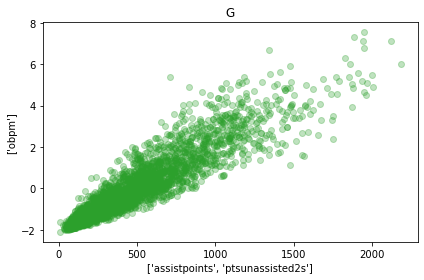

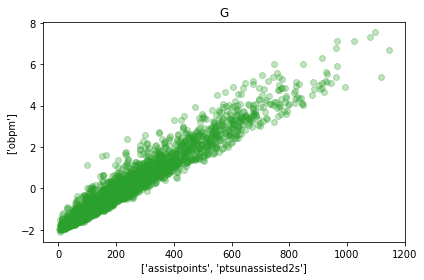

For C: R^2 between ['assistpoints', 'ptsunassisted2s'] and ['obpm']:  0.4211


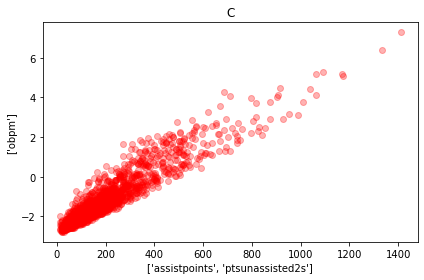

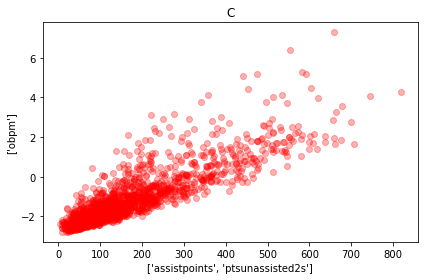

In [58]:
multiLinRegbyPos(['assistpoints', 'ptsunassisted2s'], ['obpm'])

In [50]:
up = nba.groupby('pos').get_group('G').loc[:, 'obpm']
up.head()

1   -1.8
2    6.5
4    2.6
5   -2.0
7    1.0
Name: obpm, dtype: float64

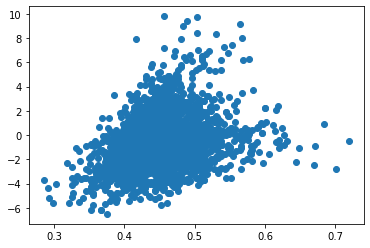

In [42]:
plt.scatter(
    list(nba.groupby('pos').get_group('F').loc[:,'fg%']),
    nba.groupby('pos').get_group('F').loc[:,'obpm'],
    color = 'k'
)

In [66]:
nba.groupby('pos').mean()

,season,age,g,gs,mp,per,ts%,3par,ftr,orb%,...,fg3ablocked,fg3apctblocked,assistpoints,twoptassists,threeptassists,atrimassists,shortmidrangeassists,longmidrangeassists,corner3assists,arc3assists
pos,,,,,,,,,,,,,,,,,,,,,
C,2011.094434,26.76798,66.183865,40.279550,1604.231395,15.904565,0.552230,0.070226,0.356874,9.747029,...,0.224515,0.015840,205.909944,62.307692,27.098186,34.560976,9.342089,18.404628,7.349593,19.748593
F,2011.073034,26.51030,65.804307,34.036517,1653.030899,14.051358,0.539423,0.262941,0.286611,5.869429,...,0.908240,0.008135,260.569757,78.771536,34.342228,44.023876,13.147940,21.599719,11.221910,23.120318
G,2011.674715,26.78169,65.104292,33.752850,1687.106304,13.694936,0.530304,0.344862,0.241910,2.522736,...,1.497988,0.008289,496.659289,158.147552,60.121395,84.878270,26.675721,46.593561,19.226023,40.895372


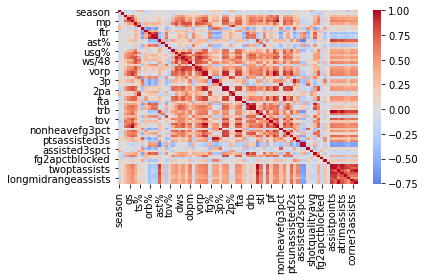

In [72]:
# All corr
sns.heatmap(nba.corr(), center=0, cmap='coolwarm')
plt.tight_layout()
plt.show()